<a href="https://colab.research.google.com/github/stanisked/aid-n_bot/blob/main/waiter_robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

СИСТЕМА ПОТОЛОЧНОГО РОБОТА-ОФИЦИАНТА

✓ Робот на точке выдачи
✓ Робот забрал напитки из бара

WaiterBot-1: Обслуживаю table_3

WaiterBot-1: Обслуживаю table_7

WaiterBot-1: Обслуживаю table_10

WaiterBot-1: Забираю посуду с table_3
WaiterBot-1: Везу в точку сброса

WaiterBot-1: Забираю посуду с table_7
WaiterBot-1: Везу в точку сброса

✓ Робот вернулся на базу

СТАТИСТИКА РАБОТЫ
Точек маршрута: 56
Общая дистанция: 151.50 метров
Действий выполнено: 55

ВИЗУАЛИЗАЦИЯ
1. Статическая схема маршрута...


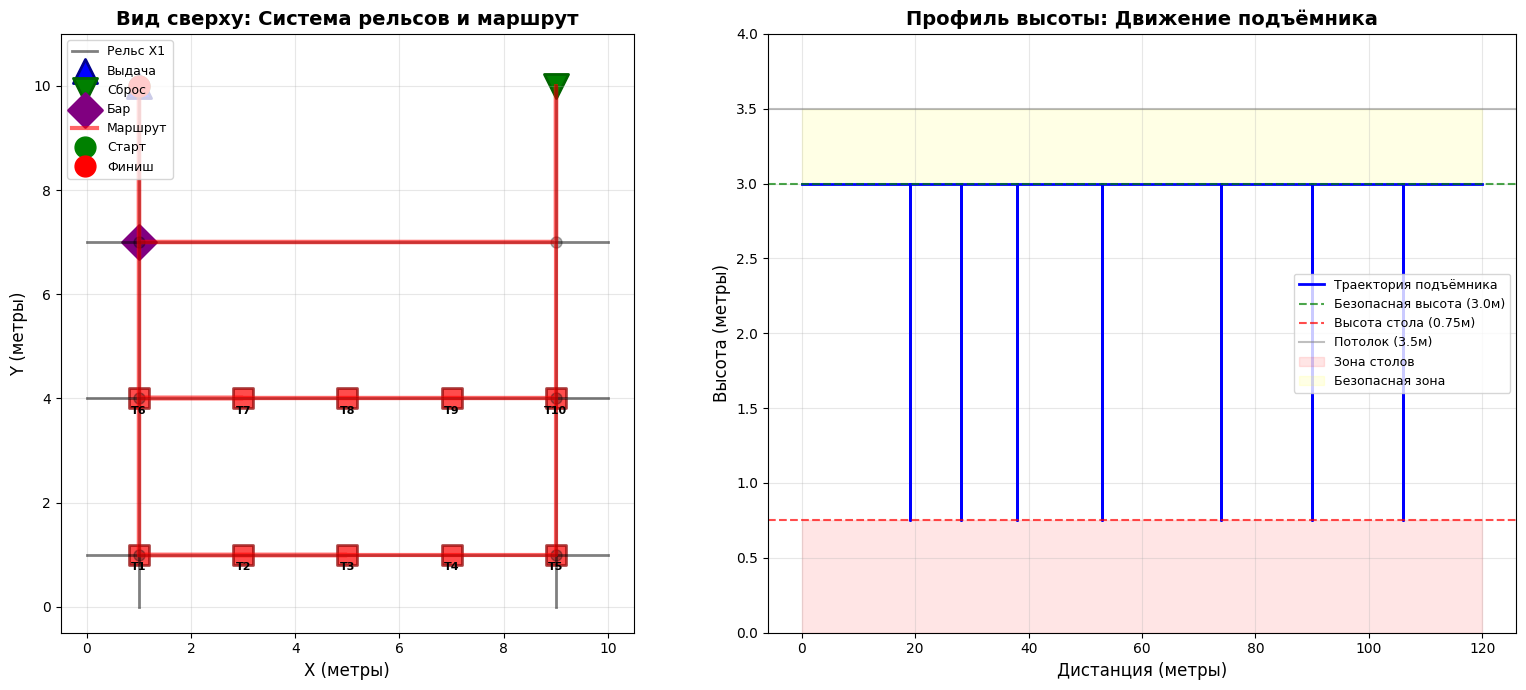


2. Анимация работы робота...
⏳ Подготовка анимации (может занять несколько секунд)...
🎬 Создаём анимацию для Google Colab...


✓ Анимация готова! Используйте плеер для управления.

3. Покадровая визуализация ключевых моментов...


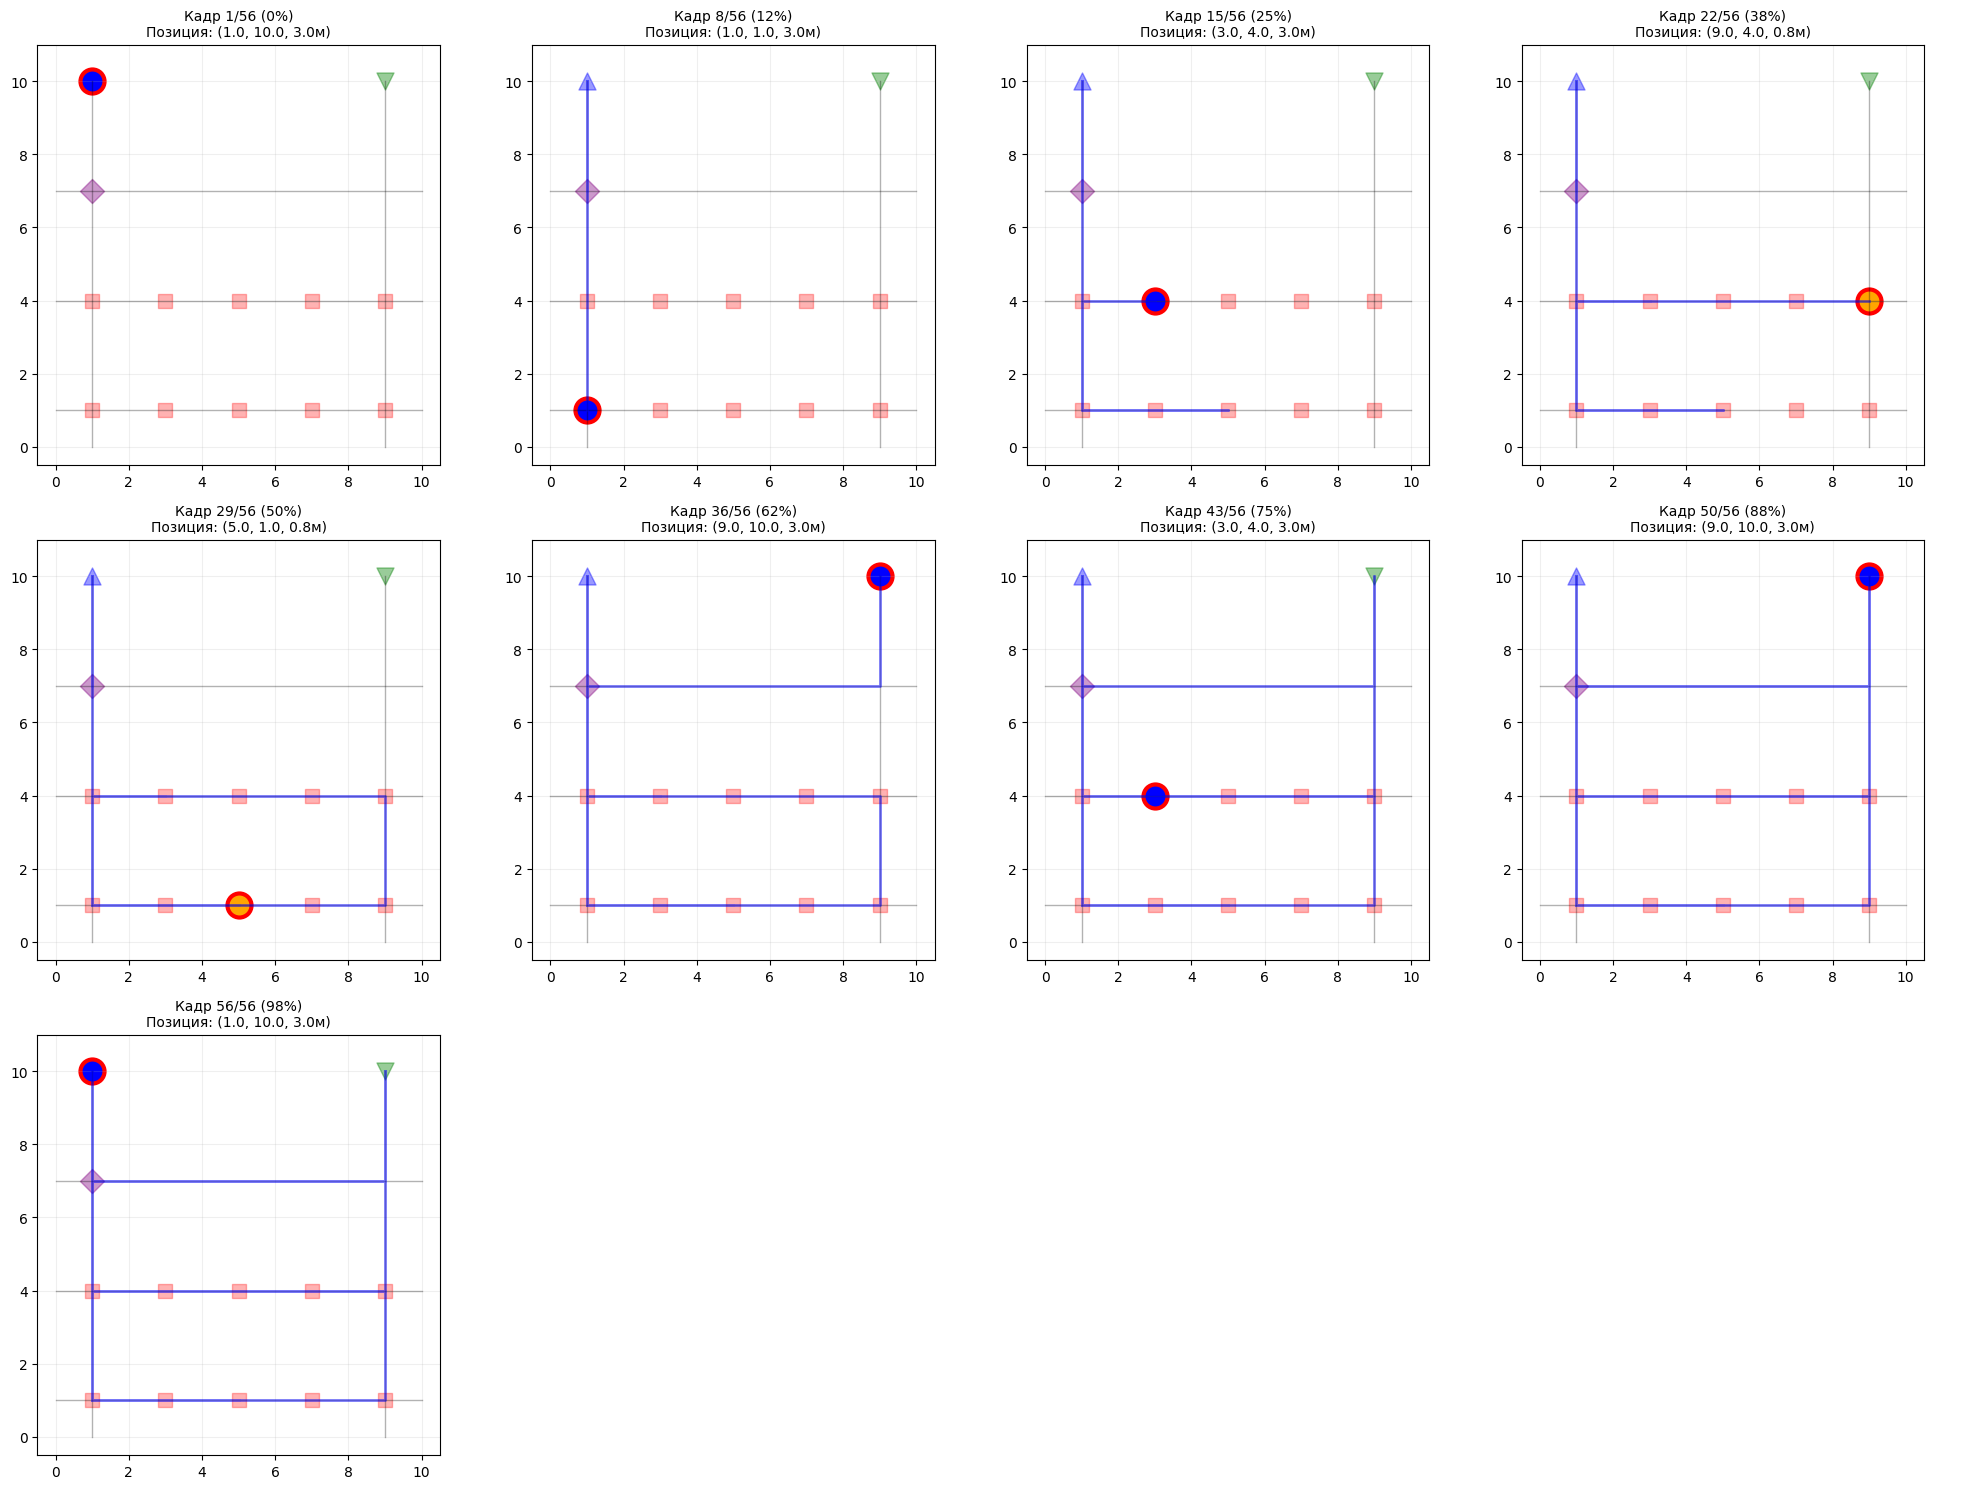


ЛОГ ДЕЙСТВИЙ (первые 20):
 1. MOVE to X3_Y1 at (1.0, 7.0, 3.0m)
 2. ARRIVE at (1.0, 10.0, 3.0m)
 3. MOVE to X3_Y1 at (1.0, 7.0, 3.0m)
 4. ARRIVE at (1.0, 7.0, 3.0m)
 5. MOVE to X3_Y1 at (1.0, 7.0, 3.0m)
 6. MOVE to X2_Y1 at (1.0, 4.0, 3.0m)
 7. MOVE to X1_Y1 at (1.0, 1.0, 3.0m)
 8. ARRIVE at (5.0, 1.0, 3.0m)
 9. LOWER at (5.0, 1.0, 0.8m)
10. SERVE table_3 at (5.0, 1.0, 0.8m)
11. LIFT at (5.0, 1.0, 3.0m)
12. MOVE to X1_Y1 at (1.0, 1.0, 3.0m)
13. MOVE to X2_Y1 at (1.0, 4.0, 3.0m)
14. ARRIVE at (3.0, 4.0, 3.0m)
15. LOWER at (3.0, 4.0, 0.8m)
16. SERVE table_7 at (3.0, 4.0, 0.8m)
17. LIFT at (3.0, 4.0, 3.0m)
18. MOVE to X2_Y1 at (1.0, 4.0, 3.0m)
19. MOVE to X2_Y2 at (9.0, 4.0, 3.0m)
20. ARRIVE at (9.0, 4.0, 3.0m)
... и ещё 35 действий

СПРАВКА ПО ВИЗУАЛИЗАЦИИ:
📊 Статическая схема - полный маршрут и профиль высоты
🎬 Анимация - движение робота в реальном времени (с плеером)
🖼️  Покадровая - ключевые моменты движения

💡 Цвета робота:
   • Синий круг - движение на безопасной высоте
   • Оранже

In [ ]:
import matplotlib.pyplot as plt
import math
import heapq
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

# Настройка для Google Colab
plt.rcParams['animation.html'] = 'jshtml'

# =========================
# КОНФИГУРАЦИЯ СИСТЕМЫ
# =========================

# Рельсы по оси X (горизонтальные)
rails_x = {
    "X1": {"y": 1, "x1": 0,  "x2": 10},
    "X2": {"y": 4, "x1": 0, "x2": 10},
    "X3": {"y": 7, "x1": 0, "x2": 10},
}

# Рельсы по оси Y (вертикальные)
rails_y = {
    "Y1": {"x": 1, "y1": 0, "y2": 10},
    "Y2": {"x": 9, "y1": 0, "y2": 10},
}

# Ключевые точки обслуживания
pickup_point = (1, 10)        # выдача готовых блюд
dirty_drop_point = (9, 10)    # сброс грязной посуды
bar_point = (1, 7)            # бар

# Столики (10 штук, расположены в 2 ряда по 5)
tables = {
    f"table_{i+1}": (i % 5 * 2 + 1, i // 5 * 3 + 1)
    for i in range(10)
}

# Параметры высот
CEILING = 3.5
CONTAINER_OFFSET = 0.5
SAFE_Z = CEILING - CONTAINER_OFFSET  # 3.0 м
TABLE_Z = 0.75                        # высота стола


# =========================
# ГЕНЕРАЦИЯ ПЕРЕСЕЧЕНИЙ РЕЛЬСОВ
# =========================

def compute_intersections(rails_x, rails_y):
    """Находит все точки пересечения X и Y рельсов"""
    intersections = {}

    for name_x, rx in rails_x.items():
        for name_y, ry in rails_y.items():
            pt = (ry["x"], rx["y"])
            intersections[f"{name_x}_{name_y}"] = {
                "name": f"{name_x}_{name_y}",
                "rail_x": name_x,
                "rail_y": name_y,
                "point": pt
            }
    return intersections


intersections = compute_intersections(rails_x, rails_y)


# =========================
# ПОСТРОЕНИЕ ГРАФА РЕЛЬСОВ
# =========================

def build_rail_graph(rails_x, rails_y, intersections):
    """Строит граф для навигации по рельсам"""
    graph = {}

    def add_edge(a, b, cost):
        graph.setdefault(a, []).append((b, cost))
        graph.setdefault(b, []).append((a, cost))

    # Рёбра по X-рельсам
    for name_x, rx in rails_x.items():
        xs = sorted(
            [(name, data["point"]) for name, data in intersections.items()
             if data["rail_x"] == name_x],
            key=lambda x: x[1][0]
        )
        for i in range(len(xs) - 1):
            n1, p1 = xs[i]
            n2, p2 = xs[i + 1]
            cost = abs(p1[0] - p2[0])
            add_edge(n1, n2, cost)

    # Рёбра по Y-рельсам
    for name_y, ry in rails_y.items():
        ys = sorted(
            [(name, data["point"]) for name, data in intersections.items()
             if data["rail_y"] == name_y],
            key=lambda x: x[1][1]
        )
        for i in range(len(ys) - 1):
            n1, p1 = ys[i]
            n2, p2 = ys[i + 1]
            cost = abs(p1[1] - p2[1])
            add_edge(n1, n2, cost)

    return graph


graph = build_rail_graph(rails_x, rails_y, intersections)


# =========================
# НАВИГАЦИЯ
# =========================

def closest_intersection(pt):
    """Находит ближайшее пересечение к заданной точке"""
    x, y = pt
    best = None
    best_dist = float('inf')

    for name, data in intersections.items():
        ix, iy = data["point"]
        d = math.sqrt((x - ix)**2 + (y - iy)**2)
        if d < best_dist:
            best_dist = d
            best = name

    return best


def find_route(start_inter, end_inter, graph):
    """Алгоритм Дейкстры для поиска кратчайшего пути"""
    queue = [(0, start_inter)]
    visited = {}
    parent = {start_inter: None}

    while queue:
        cost, node = heapq.heappop(queue)

        if node == end_inter:
            break

        if node in visited:
            continue

        visited[node] = cost

        for neigh, w in graph.get(node, []):
            if neigh not in visited:
                new_cost = cost + w
                heapq.heappush(queue, (new_cost, neigh))
                if neigh not in parent:
                    parent[neigh] = node

    # Восстановление пути
    path = []
    cur = end_inter
    while cur:
        path.append(cur)
        cur = parent.get(cur)
    path.reverse()
    return path


# =========================
# КЛАСС РОБОТА
# =========================

class CeilingRobot:
    def __init__(self, name, start=(1, 10)):
        self.name = name
        self.x, self.y = start
        self.z = SAFE_Z
        self.path = [(self.x, self.y, self.z)]
        self.log = []

    def _log(self, action):
        entry = f"{action} at ({self.x:.1f}, {self.y:.1f}, {self.z:.1f}m)"
        self.log.append(entry)
        self.path.append((self.x, self.y, self.z))

    def lift(self):
        """Поднять на безопасную высоту"""
        self.z = SAFE_Z
        self._log("LIFT")

    def lower_to_table(self):
        """Опустить к столу"""
        self.z = TABLE_Z
        self._log("LOWER")

    def move_to_point(self, target):
        """Переместиться к целевой точке через граф рельсов"""
        # Убедиться что на безопасной высоте
        if self.z != SAFE_Z:
            self.lift()

        # Найти маршрут через пересечения
        start_node = closest_intersection((self.x, self.y))
        end_node = closest_intersection(target)
        route = find_route(start_node, end_node, graph)

        # Двигаться по маршруту
        for node in route:
            x, y = intersections[node]["point"]
            self.x = x
            self.y = y
            self._log(f"MOVE to {node}")

        # Финальное движение к целевой точке
        self.x, self.y = target
        self._log("ARRIVE")

    def serve_table(self, table_name):
        """Обслужить столик"""
        table_pos = tables[table_name]
        print(f"\n{self.name}: Обслуживаю {table_name}")
        self.move_to_point(table_pos)
        self.lower_to_table()
        self._log(f"SERVE {table_name}")
        self.lift()

    def pick_up_dirty(self, table_name):
        """Забрать грязную посуду"""
        table_pos = tables[table_name]
        print(f"\n{self.name}: Забираю посуду с {table_name}")
        self.move_to_point(table_pos)
        self.lower_to_table()
        self._log(f"PICKUP from {table_name}")
        self.lift()

        print(f"{self.name}: Везу в точку сброса")
        self.move_to_point(dirty_drop_point)
        self.lower_to_table()
        self._log("DROP dirty dishes")
        self.lift()

    def get_total_distance(self):
        """Подсчитать общее расстояние"""
        total = 0
        for i in range(len(self.path) - 1):
            p1 = self.path[i]
            p2 = self.path[i + 1]
            total += math.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2 + (p2[2]-p1[2])**2)
        return total


# =========================
# ВИЗУАЛИЗАЦИЯ
# =========================

def visualize_system(robot):
    """Создать визуализацию системы и маршрута робота"""
    fig = plt.figure(figsize=(16, 7))

    # 2D вид сверху
    ax1 = plt.subplot(1, 2, 1)

    # Рельсы по X
    for name, rail in rails_x.items():
        ax1.plot([rail["x1"], rail["x2"]], [rail["y"], rail["y"]],
                'k-', linewidth=2, alpha=0.5, label=f'Рельс {name}' if name == "X1" else "")

    # Рельсы по Y
    for name, rail in rails_y.items():
        ax1.plot([rail["x"], rail["x"]], [rail["y1"], rail["y2"]],
                'k-', linewidth=2, alpha=0.5)

    # Пересечения
    for name, data in intersections.items():
        x, y = data["point"]
        ax1.plot(x, y, 'ko', markersize=8, alpha=0.3)

    # Столики
    for name, (x, y) in tables.items():
        ax1.scatter(x, y, c='red', s=200, marker='s', alpha=0.7, edgecolors='darkred', linewidth=2)
        ax1.text(x, y-0.3, name.replace('table_', 'T'), ha='center', fontsize=8, fontweight='bold')

    # Точки обслуживания
    ax1.scatter(*pickup_point, c='blue', s=300, marker='^', label='Выдача', edgecolors='darkblue', linewidth=2)
    ax1.scatter(*dirty_drop_point, c='green', s=300, marker='v', label='Сброс', edgecolors='darkgreen', linewidth=2)
    ax1.scatter(*bar_point, c='purple', s=300, marker='D', label='Бар', edgecolors='purple', linewidth=2)

    # Маршрут робота
    path_xy = [(px, py) for px, py, _ in robot.path]
    if len(path_xy) > 1:
        xs, ys = zip(*path_xy)
        ax1.plot(xs, ys, 'r-', linewidth=3, alpha=0.6, label='Маршрут')
        ax1.plot(xs[0], ys[0], 'go', markersize=15, label='Старт')
        ax1.plot(xs[-1], ys[-1], 'ro', markersize=15, label='Финиш')

    ax1.set_xlim(-0.5, 10.5)
    ax1.set_ylim(-0.5, 11)
    ax1.set_xlabel('X (метры)', fontsize=12)
    ax1.set_ylabel('Y (метры)', fontsize=12)
    ax1.set_title('Вид сверху: Система рельсов и маршрут', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')

    # 3D профиль (боковой вид)
    ax2 = plt.subplot(1, 2, 2)

    # Профиль высот
    distances = [0]
    for i in range(len(robot.path) - 1):
        p1 = robot.path[i]
        p2 = robot.path[i + 1]
        d = math.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
        distances.append(distances[-1] + d)

    heights = [z for _, _, z in robot.path]

    ax2.plot(distances, heights, 'b-', linewidth=2, label='Траектория подъёмника')
    ax2.axhline(y=SAFE_Z, color='g', linestyle='--', label=f'Безопасная высота ({SAFE_Z}м)', alpha=0.7)
    ax2.axhline(y=TABLE_Z, color='r', linestyle='--', label=f'Высота стола ({TABLE_Z}м)', alpha=0.7)
    ax2.axhline(y=CEILING, color='gray', linestyle='-', label=f'Потолок ({CEILING}м)', alpha=0.5)

    ax2.fill_between(distances, 0, TABLE_Z, alpha=0.1, color='red', label='Зона столов')
    ax2.fill_between(distances, CEILING, SAFE_Z, alpha=0.1, color='yellow', label='Безопасная зона')

    ax2.set_xlabel('Дистанция (метры)', fontsize=12)
    ax2.set_ylabel('Высота (метры)', fontsize=12)
    ax2.set_title('Профиль высоты: Движение подъёмника', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, CEILING + 0.5)

    plt.tight_layout()
    return fig

# =========================
# АНИМАЦИЯ РАБОТЫ РОБОТА
# =========================

def animate_robot(robot, speed=100, save_html=False):
    """
    Анимация движения робота в реальном времени

    Args:
        robot: объект CeilingRobot с заполненным path
        speed: скорость анимации в миллисекундах на кадр
        save_html: сохранить HTML версию для Colab (True/False)

    Returns:
        fig, anim: фигура и объект с анимацией
    """
    fig = plt.figure(figsize=(16, 7))

    # --- ЛЕВАЯ ПАНЕЛЬ: ВИД СВЕРХУ ---
    ax1 = plt.subplot(1, 2, 1)

    # Рисуем статичные элементы
    # Рельсы по X
    for name, rail in rails_x.items():
        ax1.plot([rail["x1"], rail["x2"]], [rail["y"], rail["y"]],
                'k-', linewidth=2, alpha=0.5)

    # Рельсы по Y
    for name, rail in rails_y.items():
        ax1.plot([rail["x"], rail["x"]], [rail["y1"], rail["y2"]],
                'k-', linewidth=2, alpha=0.5)

    # Пересечения
    for name, data in intersections.items():
        x, y = data["point"]
        ax1.plot(x, y, 'ko', markersize=6, alpha=0.2)

    # Столики
    for name, (x, y) in tables.items():
        ax1.scatter(x, y, c='red', s=200, marker='s', alpha=0.5, edgecolors='darkred', linewidth=2)
        ax1.text(x, y-0.3, name.replace('table_', 'T'), ha='center', fontsize=8, fontweight='bold')

    # Точки обслуживания
    ax1.scatter(*pickup_point, c='blue', s=250, marker='^', alpha=0.6, edgecolors='darkblue', linewidth=2)
    ax1.text(pickup_point[0], pickup_point[1]+0.4, 'Выдача', ha='center', fontsize=9, fontweight='bold')

    ax1.scatter(*dirty_drop_point, c='green', s=250, marker='v', alpha=0.6, edgecolors='darkgreen', linewidth=2)
    ax1.text(dirty_drop_point[0], dirty_drop_point[1]+0.4, 'Сброс', ha='center', fontsize=9, fontweight='bold')

    ax1.scatter(*bar_point, c='purple', s=250, marker='D', alpha=0.6, edgecolors='purple', linewidth=2)
    ax1.text(bar_point[0]-0.5, bar_point[1], 'Бар', ha='center', fontsize=9, fontweight='bold')

    # Динамические элементы
    trail_line, = ax1.plot([], [], 'b-', linewidth=2, alpha=0.4, label='След')
    robot_dot, = ax1.plot([], [], 'ro', markersize=20, label='Робот')
    robot_circle = Circle((0, 0), 0.3, color='red', alpha=0.2, fill=True)
    ax1.add_patch(robot_circle)

    # Текст со статусом
    status_text = ax1.text(0.02, 0.98, '', transform=ax1.transAxes,
                          fontsize=11, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax1.set_xlim(-0.5, 10.5)
    ax1.set_ylim(-0.5, 11)
    ax1.set_xlabel('X (метры)', fontsize=12)
    ax1.set_ylabel('Y (метры)', fontsize=12)
    ax1.set_title('Вид сверху: Движение робота', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')

    # --- ПРАВАЯ ПАНЕЛЬ: ПРОФИЛЬ ВЫСОТЫ ---
    ax2 = plt.subplot(1, 2, 2)

    # Вычисляем расстояния для оси X
    distances = [0]
    for i in range(len(robot.path) - 1):
        p1 = robot.path[i]
        p2 = robot.path[i + 1]
        d = math.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
        distances.append(distances[-1] + d)

    heights = [z for _, _, z in robot.path]

    # Полный путь (полупрозрачный)
    ax2.plot(distances, heights, 'gray', linewidth=1, alpha=0.3, linestyle='--', label='Полный маршрут')

    # Горизонтальные линии зон
    ax2.axhline(y=SAFE_Z, color='g', linestyle='--', label=f'Безопасная высота ({SAFE_Z}м)', alpha=0.5, linewidth=2)
    ax2.axhline(y=TABLE_Z, color='r', linestyle='--', label=f'Высота стола ({TABLE_Z}м)', alpha=0.5, linewidth=2)
    ax2.axhline(y=CEILING, color='gray', linestyle='-', label=f'Потолок ({CEILING}м)', alpha=0.3)

    # Зоны
    ax2.fill_between(distances, 0, TABLE_Z, alpha=0.1, color='red')
    ax2.fill_between(distances, CEILING, SAFE_Z, alpha=0.1, color='yellow')

    # Динамические элементы
    height_line, = ax2.plot([], [], 'b-', linewidth=3, label='Текущий путь')
    height_dot, = ax2.plot([], [], 'ro', markersize=15)

    ax2.set_xlabel('Дистанция (метры)', fontsize=12)
    ax2.set_ylabel('Высота (метры)', fontsize=12)
    ax2.set_title('Профиль высоты подъёмника', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, CEILING + 0.5)
    ax2.set_xlim(0, max(distances) + 1)

    plt.tight_layout()

    # --- ФУНКЦИЯ АНИМАЦИИ ---
    def init():
        trail_line.set_data([], [])
        robot_dot.set_data([], [])
        robot_circle.center = (0, 0)
        height_line.set_data([], [])
        height_dot.set_data([], [])
        status_text.set_text('')
        return trail_line, robot_dot, robot_circle, height_line, height_dot, status_text

    def animate(frame):
        # Текущая позиция
        x, y, z = robot.path[frame]

        # Обновляем след
        trail_x = [p[0] for p in robot.path[:frame+1]]
        trail_y = [p[1] for p in robot.path[:frame+1]]
        trail_line.set_data(trail_x, trail_y)

        # Обновляем робота
        robot_dot.set_data([x], [y])
        robot_circle.center = (x, y)

        # Определяем цвет в зависимости от высоты
        if z == SAFE_Z:
            robot_circle.set_color('blue')
            robot_circle.set_alpha(0.3)
        elif z == TABLE_Z:
            robot_circle.set_color('orange')
            robot_circle.set_alpha(0.5)

        # Обновляем профиль высоты
        height_line.set_data(distances[:frame+1], heights[:frame+1])
        height_dot.set_data([distances[frame]], [z])

        # Обновляем текст статуса
        total_dist = robot.get_total_distance()
        current_dist = distances[frame]
        progress = (frame / len(robot.path)) * 100

        status = f"Кадр: {frame+1}/{len(robot.path)}\n"
        status += f"Позиция: ({x:.1f}, {y:.1f}, {z:.1f}м)\n"
        status += f"Прогресс: {progress:.1f}%\n"
        status += f"Дистанция: {current_dist:.1f}/{total_dist:.1f}м"

        if frame < len(robot.log):
            status += f"\n{robot.log[frame]}"

        status_text.set_text(status)

        return trail_line, robot_dot, robot_circle, height_line, height_dot, status_text

    # Создаём анимацию
    anim = FuncAnimation(fig, animate, init_func=init,
                        frames=len(robot.path), interval=speed,
                        blit=True, repeat=True)

    plt.close(fig)    # Закрываем фигуру чтобы не показывать статичную версию

    return anim


def show_animation_in_colab(robot, speed=100):
    """
    Показать анимацию в Google Colab

    Args:
        robot: объект CeilingRobot
        speed: скорость анимации

    Returns:
        HTML объект с анимацией
    """
    print("🎬 Создаём анимацию для Google Colab...")
    anim = animate_robot(robot, speed=speed)
    return HTML(anim.to_jshtml())


def create_frame_by_frame_visualization(robot, frames_to_show=None):
    """
    Создать покадровую визуализацию (альтернатива для медленного Colab)

    Args:
        robot: объект CeilingRobot
        frames_to_show: список индексов кадров для показа (или None для ключевых)
    """
    if frames_to_show is None:
        # Показываем ключевые моменты
        step = max(1, len(robot.path) // 8)
        frames_to_show = list(range(0, len(robot.path), step))
        if frames_to_show[-1] != len(robot.path) - 1:
            frames_to_show.append(len(robot.path) - 1)
    n_frames = len(frames_to_show)
    cols = 4
    rows = (n_frames + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = axes.flatten() if n_frames > 1 else [axes]

    for idx, frame in enumerate(frames_to_show):
        ax = axes[idx]

        # Рисуем рельсы
        for name, rail in rails_x.items():
            ax.plot([rail["x1"], rail["x2"]], [rail["y"], rail["y"]],
                    'k-', linewidth=1, alpha=0.3)

        for name, rail in rails_y.items():
            ax.plot([rail["x"], rail["x"]], [rail["y1"], rail["y2"]],
                    'k-', linewidth=1, alpha=0.3)
        # Столики
        for name, (x, y) in tables.items():
            ax.scatter(x, y, c='red', s=100, marker='s', alpha=0.3)

        # Точки обслуживания
        ax.scatter(*pickup_point, c='blue', s=150, marker='^', alpha=0.4)
        ax.scatter(*dirty_drop_point, c='green', s=150, marker='v', alpha=0.4)
        ax.scatter(*bar_point, c='purple', s=150, marker='D', alpha=0.4)

        # Пройденный путь
        trail_x = [p[0] for p in robot.path[:frame+1]]
        trail_y = [p[1] for p in robot.path[:frame+1]]
        ax.plot(trail_x, trail_y, 'b-', linewidth=2, alpha=0.5)

        # Текущая позиция
        x, y, z = robot.path[frame]
        color = 'blue' if z == SAFE_Z else 'orange'
        ax.scatter(x, y, c=color, s=300, marker='o', edgecolors='red', linewidth=3)

        # Информация
        progress = (frame / len(robot.path)) * 100
        ax.set_title(f'Кадр {frame+1}/{len(robot.path)} ({progress:.0f}%)\n' +
                     f'Позиция: ({x:.1f}, {y:.1f}, {z:.1f}м)', fontsize=10)

        ax.set_xlim(-0.5, 10.5)
        ax.set_ylim(-0.5, 11)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)

    # Убираем лишние оси
    for idx in range(n_frames, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    return fig

# =========================
# СЦЕНАРИЙ РАБОТЫ
# =========================

print("="*60)
print("СИСТЕМА ПОТОЛОЧНОГО РОБОТА-ОФИЦИАНТА")
print("="*60)

robot = CeilingRobot("WaiterBot-1", start=pickup_point)

# Сценарий работы
robot.move_to_point(pickup_point)
print(f"\n✓ Робот на точке выдачи")

robot.move_to_point(bar_point)
print(f"✓ Робот забрал напитки из бара")

robot.serve_table("table_3")
robot.serve_table("table_7")
robot.serve_table("table_10")

robot.pick_up_dirty("table_3")
robot.pick_up_dirty("table_7")

robot.move_to_point(pickup_point)
print(f"\n✓ Робот вернулся на базу")

# Статистика
print("\n" + "="*60)
print("СТАТИСТИКА РАБОТЫ")
print("="*60)
print(f"Точек маршрута: {len(robot.path)}")
print(f"Общая дистанция: {robot.get_total_distance():.2f} метров")
print(f"Действий выполнено: {len(robot.log)}")

# Визуализация
print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ")
print("="*60)

# 1. Статическая схема
print("1. Статическая схема маршрута...")
fig_static = visualize_system(robot)
plt.show()

# 2. Анимация для Colab
print("\n2. Анимация работы робота...")
print("⏳ Подготовка анимации (может занять несколько секунд)...")

try:
    # Пробуем показать полную анимацию
    anim_html = show_animation_in_colab(robot, speed=400)
    display(anim_html)
    print("✓ Анимация готова! Используйте плеер для управления.")
except Exception as e:
    print(f"⚠ Не удалось создать анимацию: {e}")
    print("Показываем покадровую визуализацию...")
    fig_frames = create_frame_by_frame_visualization(robot)
    plt.show()

# 3. Покадровая визуализация (всегда доступна)
print("\n3. Покадровая визуализация ключевых моментов...")
fig_frames = create_frame_by_frame_visualization(robot)
plt.show()

# Вывод лога
print("\n" + "="*60)
print("ЛОГ ДЕЙСТВИЙ (первые 20):")
print("="*60)
for i, entry in enumerate(robot.log[:20], 1):
    print(f"{i:2d}. {entry}")
if len(robot.log) > 20:
    print(f"... и ещё {len(robot.log) - 20} действий")

print("\n" + "="*60)
print("СПРАВКА ПО ВИЗУАЛИЗАЦИИ:")
print("="*60)
print("📊 Статическая схема - полный маршрут и профиль высоты")
print("🎬 Анимация - движение робота в реальном времени (с плеером)")
print("🖼️  Покадровая - ключевые моменты движения")
print("\n💡 Цвета робота:")
print("   • Синий круг - движение на безопасной высоте")
print("   • Оранжевый круг - работа у стола")
print("="*60)